In [1]:
# Libraries
import numpy as np
import pandas as pd
import gym
from tqdm import tqdm
import collections

import sys
sys.path.append('../')

# RL Agents
from agents.monte_carlo_exploring_starts_agent import MonteCarloExploringStartsAgent
from agents.q_learning_agent import QLearningAgent
from agents.expected_sarsa_agent import ExpectedSarsaAgent

# Visualization
from frozen_lake_plots import plot_frozen_lake, plot_state_action_frozen_lake

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
plt.rcParams["figure.figsize"] = (12, 8)

# Frozen Lake
Notebook containing all agents for the FrozenLake-v1 environment.

## Environment Setup

In [2]:
# Environment
env = gym.make("FrozenLake-v1")
terminal_states = [5, 7, 11, 12, 15]

# Number of runs and episodes per run
num_runs = 50
num_episodes = 4000

## Auxiliary Functions

In [3]:
# Train a given model
def train_agent(env, agent_class, agent_info, terminal_states, exploring_starts = False):

    # Record num steps and rewards 
    all_num_steps = []
    all_rewards = []
    rewards_per_episode = []

    # Summary table for each run
    all_q = []

    # Iterate
    for _ in tqdm(range(num_runs)):
        
        # Initialize Agent
        agent = agent_class(agent_info)

        num_steps = 0
        total_reward = 0

        cache_num_steps = []
        cache_rewards = []

        for _ in range(num_episodes):

            # Reset env
            env.reset()

            if exploring_starts:
                # Select a random start
                state = env.observation_space.sample()
                while state in terminal_states: # Fix if starting state is terminal
                    state = env.observation_space.sample()

                # Change initial state
                env = env.unwrapped
                env.s = state
            else:
                state = env.s

            # Initial action
            action = agent.agent_start(state)
            done = False

            episode_len = 0
            episode_reward = 0

            while not done:

                episode_len += 1
                if episode_len > 1000:
                    done = True
                    break

                new_state, reward, done, _ = env.step(action)
                new_action = agent.agent_step(reward, new_state)

                # Update values
                num_steps += 1
                total_reward += reward
                episode_reward += reward

                cache_num_steps.append(num_steps)
                cache_rewards.append(total_reward)

                # Update state and action
                state, action = new_state, new_action

            # Last agent step
            agent.agent_end(reward)
            rewards_per_episode.append(episode_reward)


        # Append summary table
        all_q.append(agent.create_summary_table())

        # Add rewards and steps
        all_num_steps.append(cache_num_steps)
        all_rewards.append(cache_rewards)

    return all_num_steps, all_rewards, rewards_per_episode, all_q


In [4]:
def plot_performance(all_num_steps, all_rewards):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8), tight_layout=True)

    # All plots
    for steps, rewards in zip(all_num_steps, all_rewards):
        ax1.plot(steps, rewards)


    for steps, rewards in zip(all_num_steps, all_rewards):
        ax2.plot(steps, rewards, alpha=0.08, color="black")

    min_len = min([len(l) for l in all_num_steps])
    truncated_all_rewards = [a[:min_len] for a in all_rewards]

    ax2.plot(np.arange(min_len), np.array(truncated_all_rewards).mean(axis=0), color='blue')
        
    ax1.set_title("Agent's Performance")
    ax1.set_xlabel("Time steps")
    ax1.set_ylabel("Comulative Reward")

    ax2.set_title("Agent's Average Performance")
    ax2.set_xlabel("Time steps")
    ax2.set_ylabel("Comulative Reward")

    plt.show()

In [5]:
def get_popular_policy(all_q, is_monte_carlo = False):
    # Get the most popular policy
    if is_monte_carlo:
        total_sum = (all_q[0]).iloc[:,1:5]
        for i in range(1,len(all_q)):
            total_sum += (all_q[i]).iloc[:,1:5]

        state_actions = total_sum/len(all_q)
        state_actions["optimal_action"] = np.array(state_actions).argmax(axis=1)
        state_actions["state_value"] = np.max(state_actions.iloc[:,:4], axis=1)
        state_actions["state"] = state_actions.index

        mc_policy = dict(zip(state_actions.index, state_actions.optimal_action))
        return mc_policy, state_actions

    else:
        popular_policies = {}

        for q in all_q:

            policy = tuple(q["optimal_action"])

            if policy not in popular_policies:
                popular_policies[policy] = 1
            else:
                popular_policies[policy] += 1

        # Sorted by vpopularity
        sorted_policies = {k: v for k, v in sorted(popular_policies.items(), key=lambda item: item[1])}
        top_policy = dict(zip(range(len(list(sorted_policies.keys())[-1])), list(sorted_policies.keys())[-1]))

        for q in all_q:

            policy = tuple(q["optimal_action"])

            if list(top_policy.values()) == list(policy):
                sample_q = q 
                break

        return top_policy, sample_q

## Learning Algorithms

### Monte Carlo Exploring Starts Agent

In [6]:
# Parameters
gamma = 0.99

# Agent information
agent_class = MonteCarloExploringStartsAgent
agent_info = {"num_actions": env.action_space.n, 
              "num_states": env.observation_space.n, 
              "gamma": gamma}

# Monte Carlo Exploring Starts results
monte_carlo_results = {}

# Train Agent
monte_carlo_results["all_num_steps"], monte_carlo_results["all_rewards"], monte_carlo_results["rewards_per_episode"], monte_carlo_results["all_q"] = train_agent(env, agent_class, agent_info, terminal_states, exploring_starts = True)

100%|██████████| 50/50 [02:28<00:00,  2.96s/it]


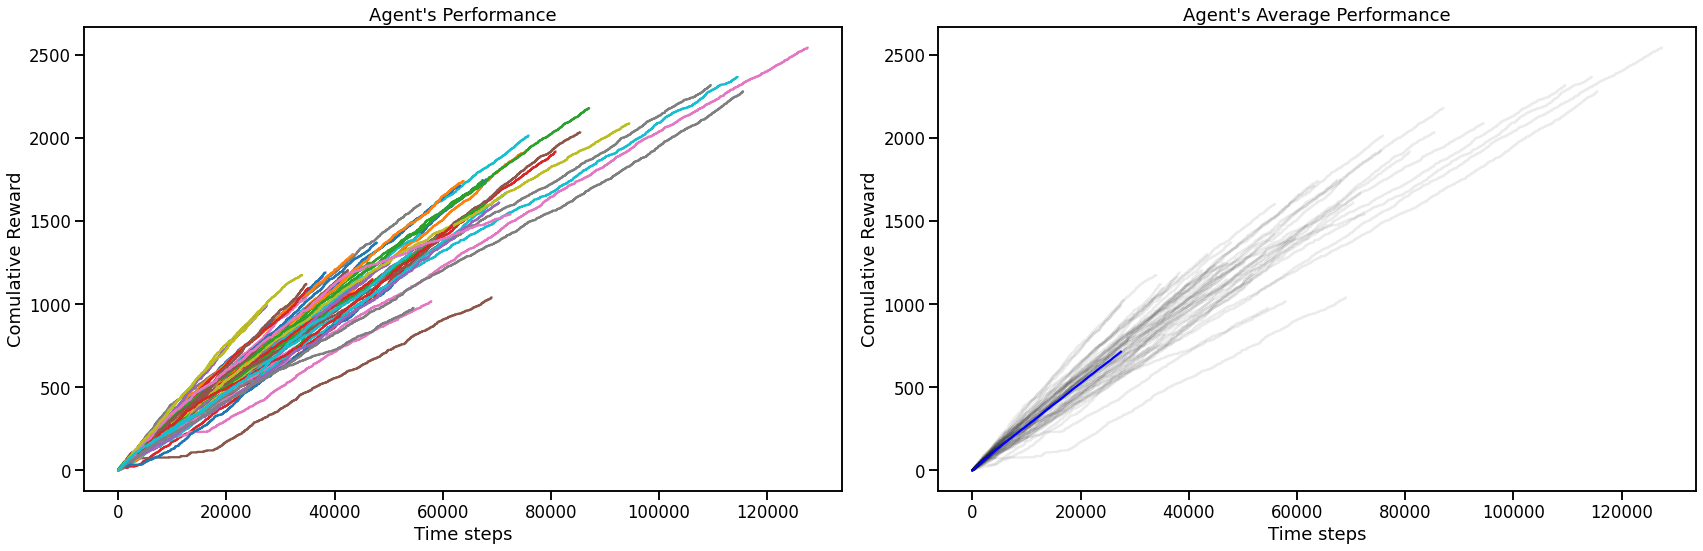

In [7]:
plot_performance(monte_carlo_results["all_num_steps"], monte_carlo_results["all_rewards"])

In [8]:
# Get top policy and state-action values
monte_carlo_top_policy, monte_carlo_sample_q = get_popular_policy(monte_carlo_results["all_q"], is_monte_carlo = True)

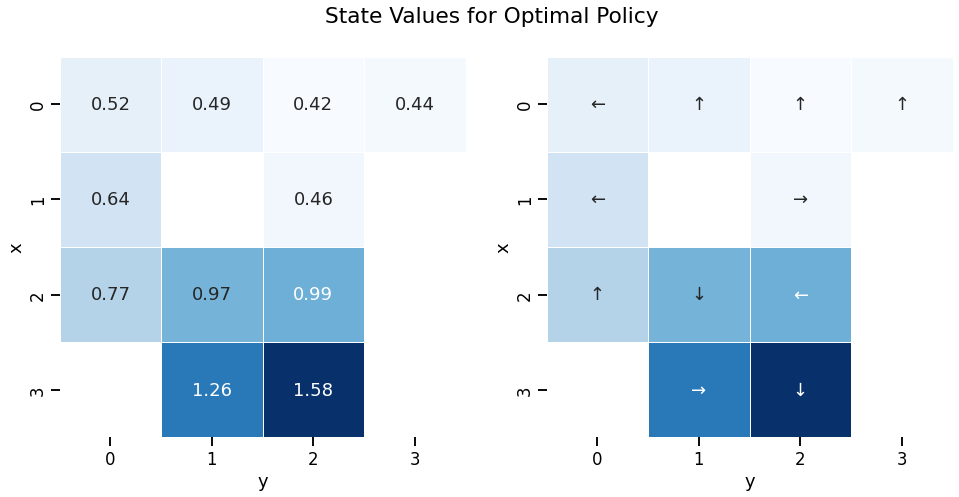

In [9]:
# State values plot
plot_frozen_lake(monte_carlo_sample_q)

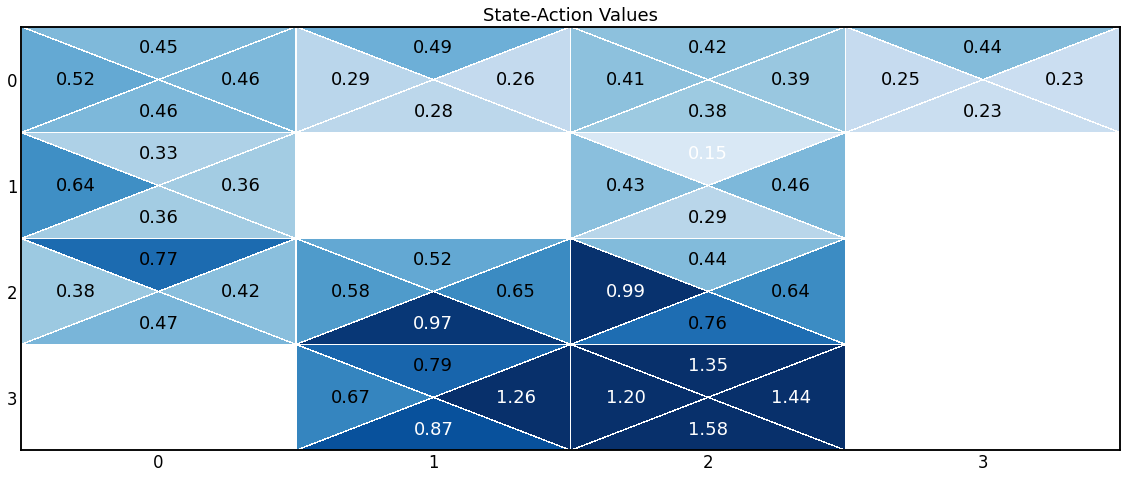

In [10]:
# State-Action values
plot_state_action_frozen_lake(monte_carlo_sample_q)

### Q-Learning Agent

In [11]:
# Parameters
epsilon = 0.05
alpha = 0.2
gamma = 0.99

# Agent information
agent_class = QLearningAgent
agent_info = {"num_actions": env.action_space.n, 
              "num_states": env.observation_space.n, 
              "epsilon": epsilon, 
              "alpha": alpha, 
              "gamma": gamma}

# Monte Carlo Exploring Starts results
q_learning_results = {}

# Train Agent
q_learning_results["all_num_steps"], q_learning_results["all_rewards"], q_learning_results["rewards_per_episode"], q_learning_results["all_q"] = train_agent(env, agent_class, agent_info, terminal_states)

100%|██████████| 50/50 [04:10<00:00,  5.00s/it]


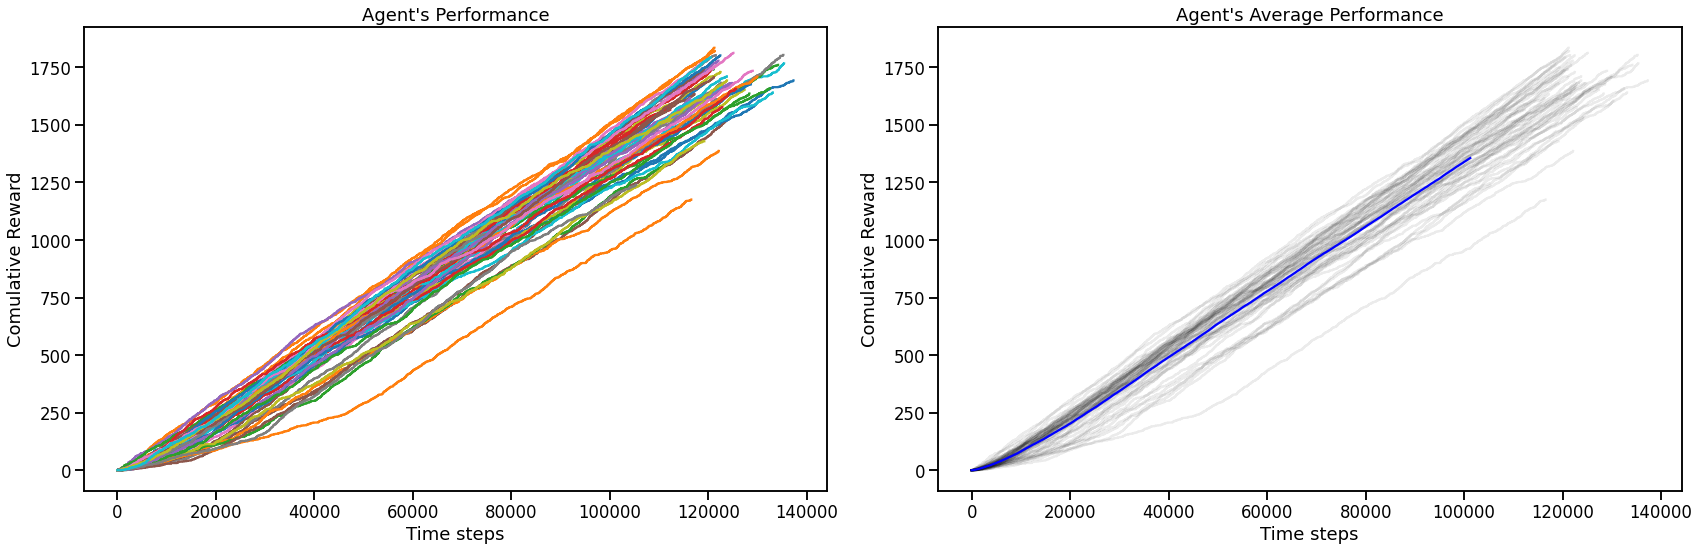

In [12]:
plot_performance(q_learning_results["all_num_steps"], q_learning_results["all_rewards"])

In [13]:
q_learning_top_policy, q_learning_sample_q = get_popular_policy(q_learning_results["all_q"])

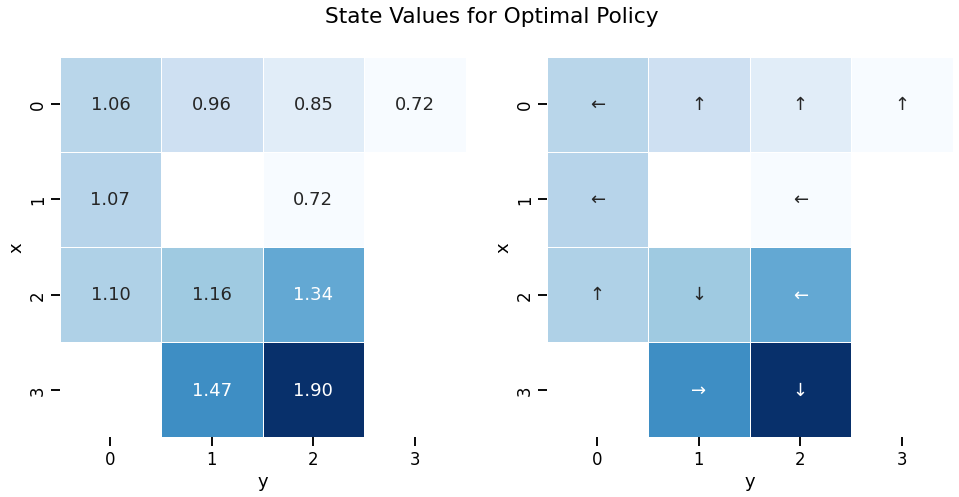

In [14]:
plot_frozen_lake(q_learning_sample_q)

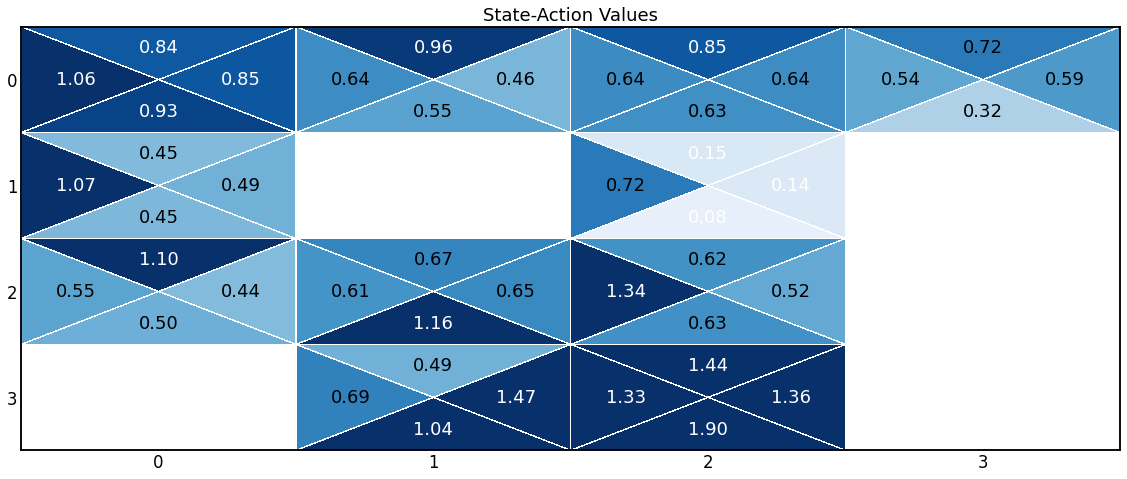

In [15]:
# State-Action values
plot_state_action_frozen_lake(q_learning_sample_q)

### Expected Sarsa

In [16]:
# Parameters
epsilon = 0.05
alpha = 0.2
gamma = 0.99

# Agent information
agent_class = ExpectedSarsaAgent
agent_info = {"num_actions": env.action_space.n, 
              "num_states": env.observation_space.n, 
              "epsilon": epsilon, 
              "alpha": alpha, 
              "gamma": gamma}

# Monte Carlo Exploring Starts results
expected_sarsa_results = {}

# Train Agent
expected_sarsa_results["all_num_steps"], expected_sarsa_results["all_rewards"], expected_sarsa_results["rewards_per_episode"], expected_sarsa_results["all_q"] = train_agent(env, agent_class, agent_info, terminal_states)

100%|██████████| 50/50 [06:54<00:00,  8.28s/it]


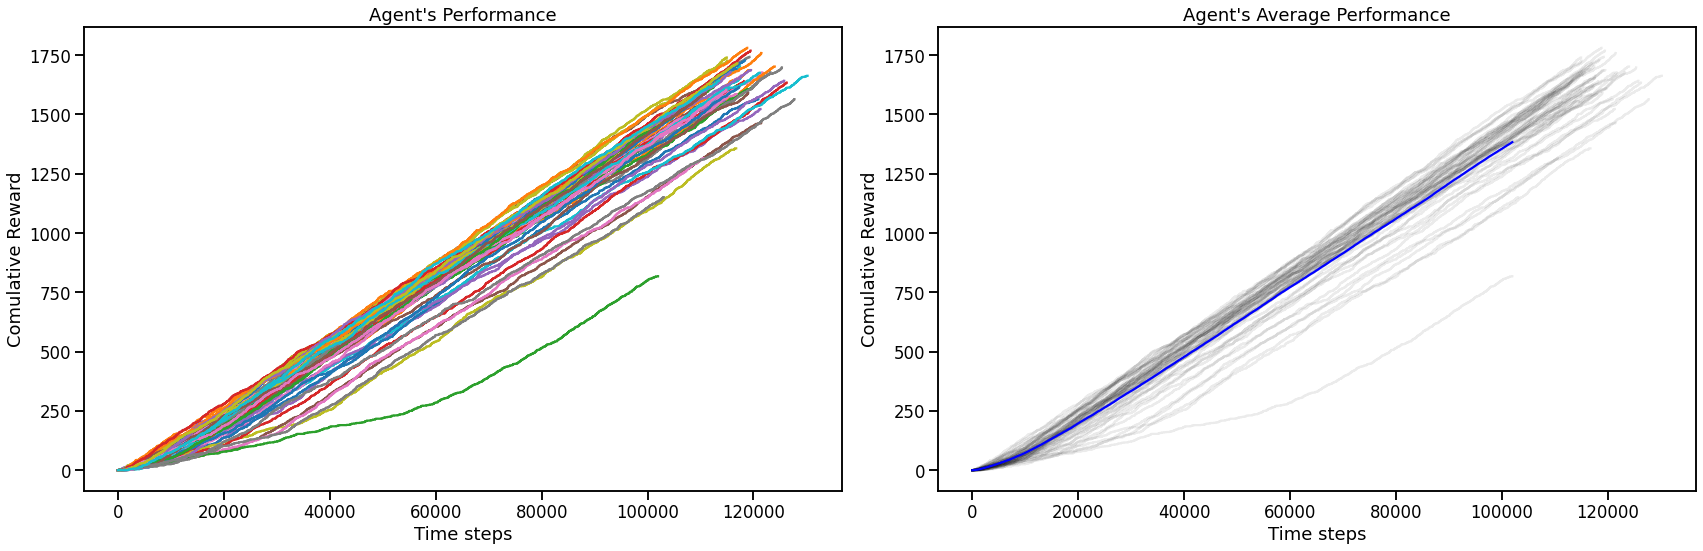

In [17]:
plot_performance(expected_sarsa_results["all_num_steps"], expected_sarsa_results["all_rewards"])

In [18]:
expected_sarsa_top_policy, expected_sarsa_sample_q = get_popular_policy(expected_sarsa_results["all_q"])

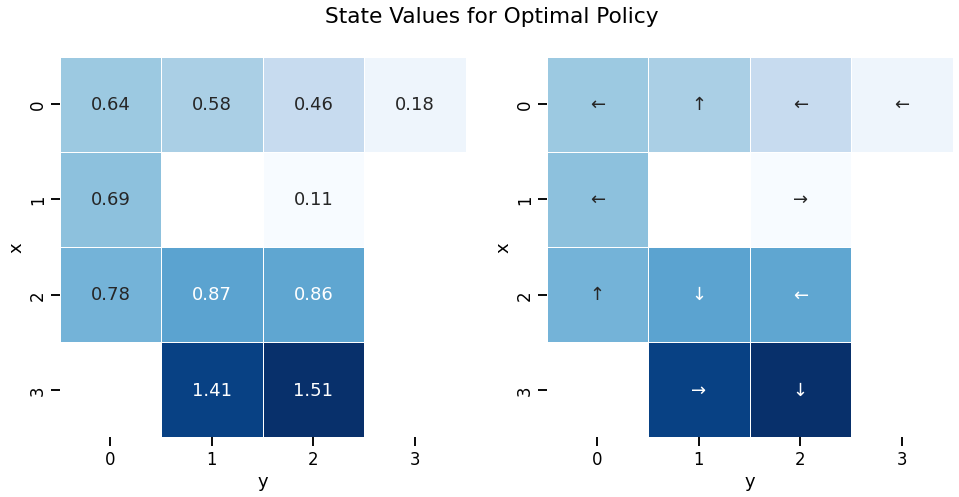

In [19]:
plot_frozen_lake(expected_sarsa_sample_q)

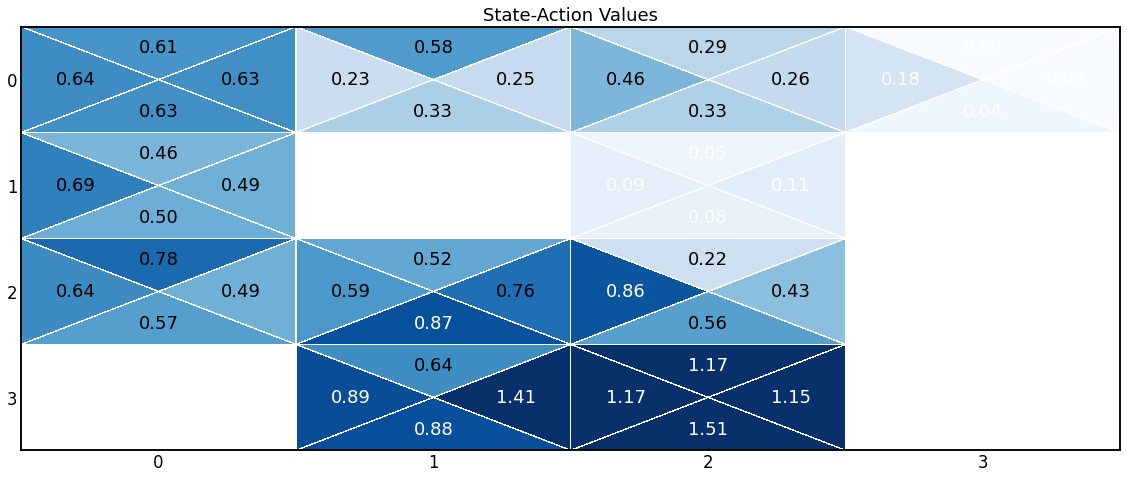

In [20]:
plot_state_action_frozen_lake(expected_sarsa_sample_q)

## Comparing Algorithms

It is important to note that Monte Carlo Exploring Starts starts in a random position rather than the real starting position, so for a fair comparison only Q-Learning and Expected Sarsa could be compared head to head.

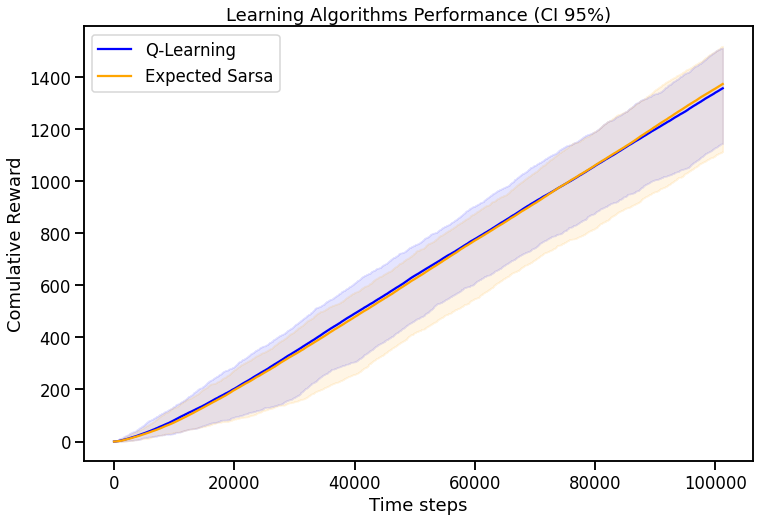

In [21]:
compare_alogrithms = {"Q-Learning": q_learning_results,
                      "Expected Sarsa": expected_sarsa_results, 
                      #"Monte Carlo ES": monte_carlo_results
                      }

colors = ["blue", "orange", "red"]

min_steps = float('inf')

for algorithm in compare_alogrithms:
    for l in compare_alogrithms[algorithm]["all_num_steps"]:
        min_steps = min(min_steps, len(l))


# Plot Comparisson
fig, ax = plt.subplots()

for idx, algorithm in enumerate(compare_alogrithms):

    truncated_all_rewards = [a[:min_steps] for a in compare_alogrithms[algorithm]["all_rewards"]]

    lower = np.percentile(truncated_all_rewards, 2.5, axis=0)
    upper = np.percentile(truncated_all_rewards, 97.5, axis=0)

    ax.plot(np.arange(min_steps), np.array(truncated_all_rewards).mean(axis=0), label=algorithm, color = colors[idx])
    ax.fill_between(np.arange(min_steps), lower, upper, color = colors[idx], alpha=.1)

ax.legend()

ax.set_title('Learning Algorithms Performance (CI 95%)')
ax.set_xlabel("Time steps")
ax.set_ylabel("Comulative Reward")

plt.show()

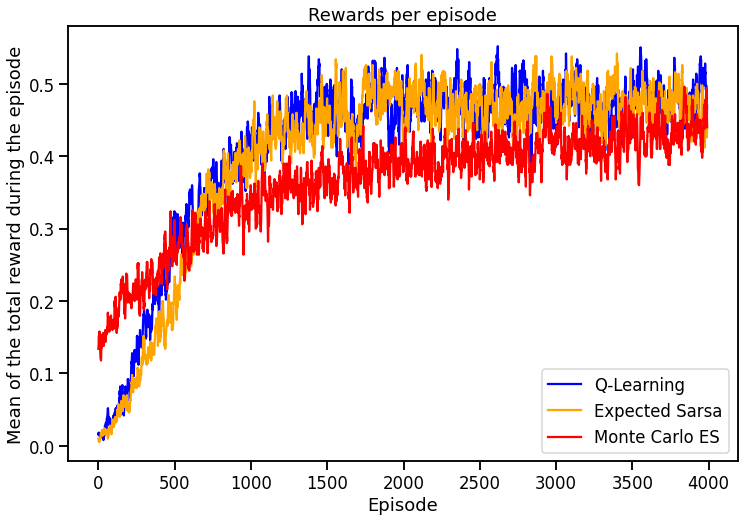

In [22]:
compare_alogrithms = {"Q-Learning": q_learning_results,
                      "Expected Sarsa": expected_sarsa_results, 
                      "Monte Carlo ES": monte_carlo_results
                      }

# Plot Comparisson
fig, ax = plt.subplots()

# Moving Average
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

for idx, algorithm in enumerate(compare_alogrithms):

    average_score = np.array(compare_alogrithms[algorithm]['rewards_per_episode']).reshape(num_runs, num_episodes).mean(axis=0)
    moving_average_score = moving_average(average_score, 10)

    ax.plot(np.arange(len(moving_average_score)), moving_average_score, label=algorithm, color = colors[idx])

ax.legend()

ax.set_title('Rewards per episode')
ax.set_xlabel("Episode")
ax.set_ylabel("Mean of the total reward during the episode")

plt.show()


In [23]:
import collections
size = (4,4)

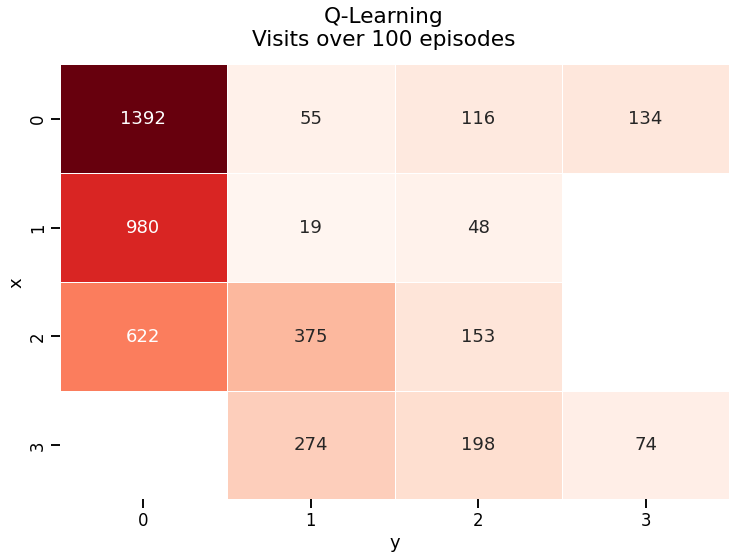

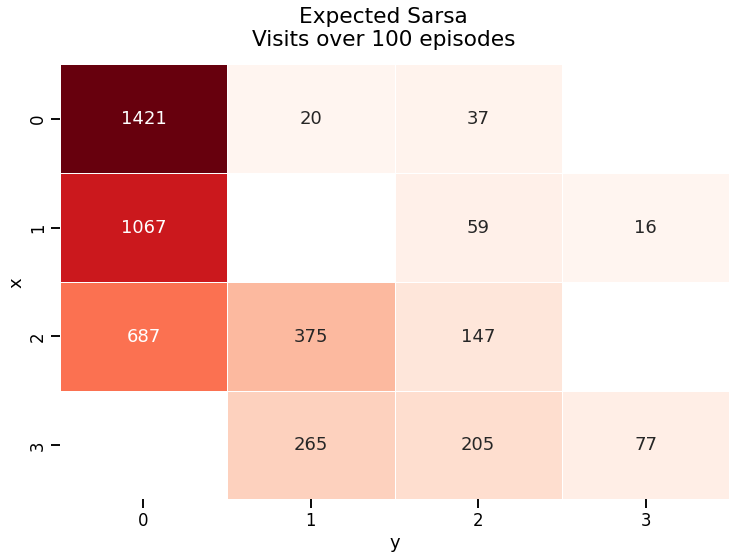

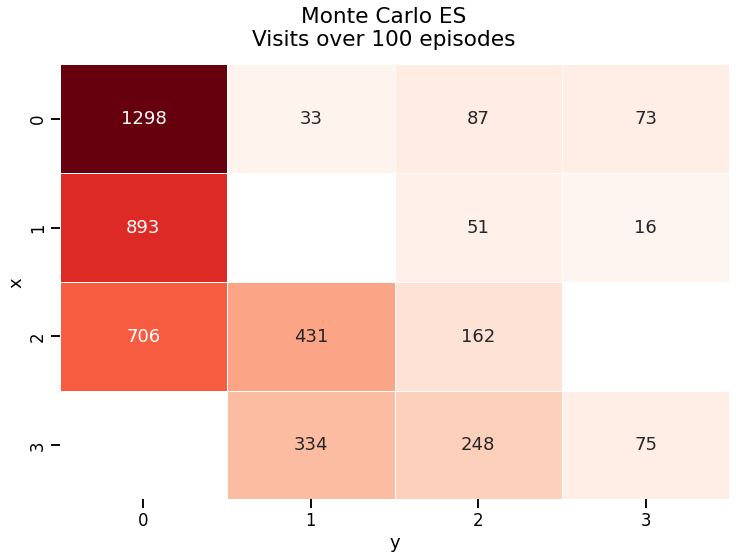

In [24]:
# Set number of games
num_games = 100

all_policies = {"Q-Learning": q_learning_top_policy,
               "Expected Sarsa": expected_sarsa_top_policy, 
                "Monte Carlo ES": monte_carlo_top_policy
                }


for policy_name in all_policies:


    policy = all_policies[policy_name]
    states = []

    for _ in range(num_games):

        # Reset env
        env.reset()
        state = env.s
        states.append(state)

        # Initial action
        action = policy[state]
        done = False

        while not done:

            new_state, reward, done, _ = env.step(action)
            new_action = policy[new_state]

            # Update state and action
            state, action = new_state, new_action
            states.append(state)

    counter = dict(collections.Counter(states))

    freqs = pd.DataFrame.from_dict(counter, orient='index').reset_index().rename(columns={'index':"state", 0:"freq"})
    freqs["x"] = freqs["state"].apply(lambda x: x//size[0])
    freqs["y"] = freqs["state"].apply(lambda x: x%size[1])

    # Reshape Data
    returns = freqs.pivot("x", "y", "freq")

    # Plot
    fig, axes = plt.subplots()
    fig.suptitle(f'{policy_name}\nVisits over {num_games} episodes')

    sns.heatmap(returns, annot=True, linewidths=.5, cbar=False, cmap="Reds",fmt='g');

In [26]:
gym.envs.register(
    id="FrozenLake-v1_dev",
    entry_point="gym.envs.toy_text:FrozenLakeEnv",
    kwargs={"map_name": "4x4"},
    max_episode_steps=100000,
    reward_threshold=0.70,  # optimum = 0.74
)

In [28]:
# Set number of games

num_reps = 1000
num_games = 100

all_policies = {"Monte Carlo ES": monte_carlo_top_policy,
                "Q-Learning": q_learning_top_policy,
                "Expected Sarsa": expected_sarsa_top_policy, 
                }

results = {}
results_steps = {}


for policy_name in all_policies:

    results[policy_name] = []
    results_steps[policy_name] = []

    for _ in range(num_reps):

        cum_reward = 0
        num_steps = 0

        policy = all_policies[policy_name]

        for _ in range(num_games):

            # Reset env
            env_dev.reset()
            state = env_dev.s

            # Initial action
            action = policy[state]
            done = False

            while not done:

                new_state, reward, done, _ = env_dev.step(action)
                new_action = policy[new_state]

                # Update reward
                num_steps += 1
                cum_reward += reward

                # Update state and action
                state, action = new_state, new_action

        results[policy_name].append(cum_reward/num_games)
        results_steps[policy_name].append(cum_reward/num_steps)


    print("Average reward for {}: {:.3f}, SD={:.3f}".format(policy_name, np.mean(results[policy_name]), np.std(results[policy_name]) ))
    print("Average reward per step for {}: {:.5f}, SD={:.3f}".format(policy_name, np.mean(results_steps[policy_name]), np.std(results_steps[policy_name]) ))

Average reward for Monte Carlo ES: 0.823, SD=0.040
Average reward per step for Monte Carlo ES: 0.01695, SD=0.002
Average reward for Q-Learning: 0.824, SD=0.038
Average reward per step for Q-Learning: 0.01700, SD=0.002
Average reward for Expected Sarsa: 0.778, SD=0.042
Average reward per step for Expected Sarsa: 0.01799, SD=0.002
